In [ ]:
!pip install torch torchvision -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 10.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset,random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import torchvision
import numpy as np
import time, os, copy, random
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.0+cu117
Torchvision Version:  0.15.1+cu117


# Create artifical data
Set random seeds.

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

Set the number of batches and the batch size. For these early tests, 5 batches of size 3 should give good insights while not being to complicated.

In [ ]:
n_batches = 10
n_train_batches = 7
batch_size = 4
n_samples = n_batches * batch_size

The network architecture, initial weights is similar to this source:
https://www.kaggle.com/code/sironghuang/understanding-pytorch-hooks.

In the linked notebook, only one datapoint is evaluated. Here, this datapoint will be repeated to include the effects of using batches.

In [ ]:
artifical_data = torch.rand(size=(n_samples,2))
print(f'dataset size :{artifical_data.shape}')
print(f'single sample, size: {artifical_data[0,:].shape} | values: {artifical_data[0,:]}')

dataset size :torch.Size([40, 2])
single sample, size: torch.Size([2]) | values: tensor([0.4963, 0.7682])


In [ ]:
artifical_labels = ((artifical_data[:,0]**2 + artifical_data[:,1]**2) < 0.7).int().unsqueeze(1)
print(f'label set size :{artifical_labels.shape}')
print(f'single label, size: {artifical_labels[0,:].shape} | values: {artifical_labels[0,:]}')

label set size :torch.Size([40, 1])
single label, size: torch.Size([1]) | values: tensor([0], dtype=torch.int32)


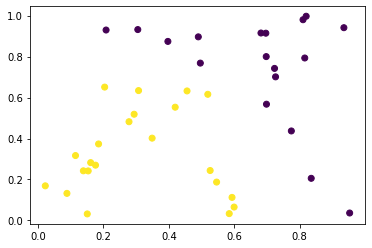

In [ ]:
plt.scatter(artifical_data[:,0],artifical_data[:,1],c=artifical_labels[:,0])

Next, the datasets and dataloader are created from the tensors. The first 4*batch_size samples are being used as the training set and the remaining batch_size samples are the test set. The splitting of datasets is not necessary for now but will make extension easy later on.

Tensordata requires a 2D tensor, where each line represents one training sample. Targets may be 1-D or 2-D.

In [ ]:
train_set = TensorDataset(artifical_data[:n_train_batches*batch_size,], artifical_labels[:n_train_batches*batch_size,])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
print(f'Number of datapoints in the training set is {len(train_set)}')

Number of datapoints in the training set is 28


In [ ]:
eval_set = TensorDataset(artifical_data[n_train_batches*batch_size:,], artifical_labels[n_train_batches*batch_size:,])
eval_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
print(f'Number of datapoints in the evaluation set is {len(eval_set)}')

Number of datapoints in the evaluation set is 12


In [ ]:
dataloaders = {'train':train_loader,
               'eval':eval_loader}

# Create sample model
The base model architecture and weights are taken from [here](https://www.kaggle.com/code/sironghuang/understanding-pytorch-hooks) for reference.

In [ ]:
class TestModel(nn.Module):
  def __init__(self, dropout_rate = 0.5):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2,2)
        self.s1 = nn.Sigmoid()
        self.do1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(2,1)
        self.s2 = nn.Sigmoid()

  def forward(self, x):
      # x = self.flatten(x)
      x= self.fc1(x)
      x = self.s1(x)
      x = self.do1(x)
      x= self.fc2(x)
      x = self.s2(x)
      return x

In [ ]:
model = TestModel()
print(model)

TestModel(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (s1): Sigmoid()
  (do1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
  (s2): Sigmoid()
)


In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: fc1.weight | Size: torch.Size([2, 2]) | Values : tensor([[-0.6590,  0.6283],
        [ 0.5377, -0.7054]], grad_fn=<SliceBackward0>) 

Layer: fc1.bias | Size: torch.Size([2]) | Values : tensor([ 0.1324, -0.1191], grad_fn=<SliceBackward0>) 

Layer: fc2.weight | Size: torch.Size([1, 2]) | Values : tensor([[-0.1164, -0.3237]], grad_fn=<SliceBackward0>) 

Layer: fc2.bias | Size: torch.Size([1]) | Values : tensor([0.2719], grad_fn=<SliceBackward0>) 



# Prepare pretraining optimizer and loss function

In [ ]:
adam_parameters = {
    'lr':1e-3,              # 1e-3
    'betas':(0.9,0.999),    # (0.9,0.999)
    'eps':1e-08,            # 1e-08
    'weight_decay':0.01     # 0.01
    # rest also standard
}
pretrain_optimizer = torch.optim.AdamW(model.parameters(), **adam_parameters)

In [ ]:
loss_fn = nn.BCELoss()

# Training Loop

In [ ]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    n_train_batches = len(dataloaders['train'])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        ########## train phase ##########
        phase = 'train'
        model.train()

        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(dataloaders[phase]):
          model.train()
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels.float())
          loss.backward()          
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          preds = (outputs>0.5).int()
          running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        ########## eval phase ##########
        phase = 'eval'
        model.eval()

        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(dataloaders[phase]):
          # disable gradient tracking for speedup
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.float())
            preds = (outputs>0.5).int()

          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))  

        val_acc_history.append(epoch_acc)
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return val_acc_history

# Pretraining the model

In [ ]:
hist = train_model(model,
                   dataloaders,
                   loss_fn,
                   pretrain_optimizer,
                   num_epochs=3
                   )

Epoch 0/2
----------
train Loss: 0.7156 Acc: 0.3571
eval Loss: 0.6928 Acc: 0.5357

Epoch 1/2
----------
train Loss: 0.6911 Acc: 0.4643
eval Loss: 0.6928 Acc: 0.5357

Epoch 2/2
----------
train Loss: 0.6922 Acc: 0.4286
eval Loss: 0.6927 Acc: 0.5357

Training complete in 0m 0s


# Getting infos about the state of the pretrained model + optimizer

In [ ]:
pretrain_state = pretrain_optimizer.state
pretrain_state_dict = pretrain_optimizer.state_dict()

In [ ]:
model.state_dict()

OrderedDict([('fc1.weight', tensor([[-0.6540,  0.6302],
                      [ 0.5404, -0.7041]])),
             ('fc1.bias', tensor([ 0.1213, -0.1268])),
             ('fc2.weight', tensor([[-0.1059, -0.3160]])),
             ('fc2.bias', tensor([0.2736]))])

In [ ]:
pretrain_state_dict['state']

{0: {'step': tensor(21.), 'exp_avg': tensor([[-0.0012, -0.0012],
          [-0.0071, -0.0068]]), 'exp_avg_sq': tensor([[4.1392e-07, 4.8464e-07],
          [5.3632e-06, 5.2507e-06]])},
 1: {'step': tensor(21.),
  'exp_avg': tensor([0.0022, 0.0010]),
  'exp_avg_sq': tensor([1.4041e-06, 1.5512e-05])},
 2: {'step': tensor(21.),
  'exp_avg': tensor([[-0.0408, -0.0066]]),
  'exp_avg_sq': tensor([[0.0006, 0.0005]])},
 3: {'step': tensor(21.),
  'exp_avg': tensor([-0.0100]),
  'exp_avg_sq': tensor([0.0013])}}

# Changes to make
- hand the weights and exp_avg_sq from the pretrained model to the adamw optimizer
- We need to correct the exp_avg_sq from the pretrained model to the normalized one.

In [ ]:
adam_parameters = {
    'lr':1e-3,              # 1e-3
    'betas':(0.9,0.999),    # (0.9,0.999)
    'eps':1e-08,            # 1e-08
    'weight_decay':0.01     # 0.01
    # rest also standard
}
finetune_optimizer = AdamW_modified(model.parameters(), **adam_parameters)

In [ ]:
pretrain_optimizer.state[pretrain_optimizer.param_groups[0]['params'][0]]

{'step': tensor(21.), 'exp_avg': tensor([[-0.0012, -0.0012],
         [-0.0071, -0.0068]]), 'exp_avg_sq': tensor([[4.1392e-07, 4.8464e-07],
         [5.3632e-06, 5.2507e-06]])}

In [ ]:
pretrain_optimizer.state

defaultdict(dict, {Parameter containing:
             tensor([[-0.6445,  0.6382],
                     [ 0.5439, -0.7025]], requires_grad=True): {'step': tensor(21.),
              'exp_avg': tensor([[-0.0012, -0.0012],
                      [-0.0071, -0.0068]]),
              'exp_avg_sq': tensor([[4.1392e-07, 4.8464e-07],
                      [5.3632e-06, 5.2507e-06]])},
             Parameter containing:
             tensor([ 0.1194, -0.1354], requires_grad=True): {'step': tensor(21.),
              'exp_avg': tensor([0.0022, 0.0010]),
              'exp_avg_sq': tensor([1.4041e-06, 1.5512e-05])},
             Parameter containing:
             tensor([[-0.1042, -0.3075]], requires_grad=True): {'step': tensor(21.),
              'exp_avg': tensor([[-0.0408, -0.0066]]),
              'exp_avg_sq': tensor([[0.0006, 0.0005]])},
             Parameter containing:
             tensor([0.2752], requires_grad=True): {'step': tensor(21.),
              'exp_avg': tensor([-0.0100]),
       

In [ ]:
pretrain_optimizer.state_dict()

{'state': {0: {'step': tensor(21.), 'exp_avg': tensor([[-0.0012, -0.0012],
           [-0.0071, -0.0068]]), 'exp_avg_sq': tensor([[4.1392e-07, 4.8464e-07],
           [5.3632e-06, 5.2507e-06]])},
  1: {'step': tensor(21.),
   'exp_avg': tensor([0.0022, 0.0010]),
   'exp_avg_sq': tensor([1.4041e-06, 1.5512e-05])},
  2: {'step': tensor(21.),
   'exp_avg': tensor([[-0.0408, -0.0066]]),
   'exp_avg_sq': tensor([[0.0006, 0.0005]])},
  3: {'step': tensor(21.),
   'exp_avg': tensor([-0.0100]),
   'exp_avg_sq': tensor([0.0013])}},
 'param_groups': [{'lr': 0.001,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0.01,
   'amsgrad': False,
   'foreach': None,
   'maximize': False,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1, 2, 3]}]}

In [ ]:
hist = train_model(model,
                   dataloaders,
                   loss_fn,
                   finetune_optimizer,
                   num_epochs=3
                   )

Epoch 0/2
----------
train Loss: 0.7030 Acc: 0.5000
eval Loss: 0.6926 Acc: 0.5357

Epoch 1/2
----------
train Loss: 0.6858 Acc: 0.5714
eval Loss: 0.6925 Acc: 0.5357

Epoch 2/2
----------
train Loss: 0.7219 Acc: 0.3929
eval Loss: 0.6924 Acc: 0.5357

Training complete in 0m 0s


In [ ]:
import torch
from torch import Tensor
from torch.optim.optimizer import (Optimizer, _use_grad_for_differentiable, _get_value, _dispatch_sqrt,
                        _stack_if_compiling, _capturable_doc, _differentiable_doc, _foreach_doc,
                        _fused_doc, _maximize_doc, _default_to_fused_or_foreach)
from typing import List, Optional
from torch.utils._foreach_utils import _group_tensors_by_device_and_dtype

__all__ = ["AdamW", "adamw"]


class AdamW_modified(Optimizer):
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=1e-2,
        amsgrad=False,
        reference_state=None,
        *,
        maximize: bool = False,
        foreach: Optional[bool] = None,
        capturable: bool = False,
        differentiable: bool = False,
        fused: Optional[bool] = None,
    ):
        self.reference_state= reference_state
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            amsgrad=amsgrad,
            foreach=foreach,
            maximize=maximize,
            capturable=capturable,
            differentiable=differentiable,
            fused=fused,
        )
        super().__init__(params, defaults)

        if fused:
            if differentiable:
                raise RuntimeError("`fused` does not support `differentiable`")
            self._step_supports_amp_scaling = True
            # TODO(crcrpar): [low prec params & their higher prec copy]
            # Suppor AMP with FP16/BF16 model params which would need
            # higher prec copy of params to do update math in higher prec to
            # alleviate the loss of information.
            if not all(
                p.is_cuda and torch.is_floating_point(p)
                for pg in self.param_groups for p in pg['params']
            ):
                raise RuntimeError("`fused=True` requires all the params to be CUDA, floating point Tensor")
            if foreach:
                raise RuntimeError("`fused` and `foreach` cannot be `True` together.")
        
    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault("amsgrad", False)
            group.setdefault("maximize", False)
            group.setdefault("foreach", None)
            group.setdefault("capturable", False)
            group.setdefault("differentiable", False)
            group.setdefault("fused", None)
        state_values = list(self.state.values())
        step_is_tensor = (len(state_values) != 0) and torch.is_tensor(
            state_values[0]["step"]
        )
        if not step_is_tensor:
            for s in state_values:
                s["step"] = torch.tensor(float(s["step"]))

    def _init_group(
        self,
        group,
        params_with_grad,
        grads,
        amsgrad,
        exp_avgs,
        exp_avg_sqs,
        max_exp_avg_sqs,
        state_steps,
        ref_parameters,
        ref_norm_avg_sqs
    ):
        for p in group["params"]:
            if p.grad is None:
                continue
            params_with_grad.append(p)
            if p.grad.is_sparse:
                raise RuntimeError("AdamW does not support sparse gradients")
            grads.append(p.grad)

            state = self.state[p]

            # State initialization
            if len(state) == 0:
                # note(crcrpar): Deliberately host `step` on CPU if both capturable and fused are off.
                # This is because kernel launches are costly on CUDA and XLA.
                state["step"] = (
                    torch.zeros((), dtype=torch.float, device=p.device)
                    if group["capturable"] or group["fused"]
                    else torch.tensor(0.0)
                )
                # Exponential moving average of gradient values
                state["exp_avg"] = torch.zeros_like(
                    p, memory_format=torch.preserve_format
                )
                # Exponential moving average of squared gradient values
                state["exp_avg_sq"] = torch.zeros_like(
                    p, memory_format=torch.preserve_format
                )
                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state["max_exp_avg_sq"] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )
                # # attach reference parameters
                if self.reference_state is not None:
                  # ref_avg_sq should be normalized, especially for pretrained models
                  # with small number of steps. For now assume steps >> 0 and therefore
                  # (1-beta2^step) = 1
                  state["ref_norm_exp_avg_sq"] = self.reference_state[p]["exp_avg_sq"]
                  # 
                  state["ref_parameters"] = p
                  

            exp_avgs.append(state["exp_avg"])
            exp_avg_sqs.append(state["exp_avg_sq"])

            if amsgrad:
                max_exp_avg_sqs.append(state["max_exp_avg_sq"])

            ref_parameters.append(state["ref_parameters"])
            ref_norm_avg_sqs.append(state["ref_norm_exp_avg_sq"])

            state_steps.append(state["step"])

    @_use_grad_for_differentiable
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        self._cuda_graph_capture_health_check()

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            amsgrad = group["amsgrad"]
            beta1, beta2 = group["betas"]
            ref_parameters = []
            ref_norm_avg_sqs = []

            self._init_group(
                group,
                params_with_grad,
                grads,
                amsgrad,
                exp_avgs,
                exp_avg_sqs,
                max_exp_avg_sqs,
                state_steps,
                ref_parameters,
                ref_norm_avg_sqs
            )

            adamw_modified(
                params_with_grad,
                grads,
                exp_avgs,
                exp_avg_sqs,
                max_exp_avg_sqs,
                state_steps,
                amsgrad=amsgrad,
                beta1=beta1,
                beta2=beta2,
                lr=group["lr"],
                weight_decay=group["weight_decay"],
                eps=group["eps"],
                maximize=group["maximize"],
                foreach=group["foreach"],
                capturable=group["capturable"],
                differentiable=group["differentiable"],
                fused=group["fused"],
                grad_scale=getattr(self, "grad_scale", None),
                found_inf=getattr(self, "found_inf", None),
                ref_parameters=ref_parameters,
                ref_norm_avg_sqs=ref_norm_avg_sqs
            )

        return loss


AdamW_modified.__doc__ = r"""Implements AdamW algorithm.
    .. math::
       \begin{aligned}
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{input}      : \gamma \text{(lr)}, \: \beta_1, \beta_2
                \text{(betas)}, \: \theta_0 \text{(params)}, \: f(\theta) \text{(objective)},
                \: \epsilon \text{ (epsilon)}                                                    \\
            &\hspace{13mm}      \lambda \text{(weight decay)},  \: \textit{amsgrad},
                \: \textit{maximize}                                                             \\
            &\textbf{initialize} : m_0 \leftarrow 0 \text{ (first moment)}, v_0 \leftarrow 0
                \text{ ( second moment)}, \: \widehat{v_0}^{max}\leftarrow 0              \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\
            &\hspace{5mm}\textbf{if} \: \textit{maximize}:                                       \\
            &\hspace{10mm}g_t           \leftarrow   -\nabla_{\theta} f_t (\theta_{t-1})          \\
            &\hspace{5mm}\textbf{else}                                                           \\
            &\hspace{10mm}g_t           \leftarrow   \nabla_{\theta} f_t (\theta_{t-1})           \\
            &\hspace{5mm} \theta_t \leftarrow \theta_{t-1} - \gamma \lambda \theta_{t-1}         \\
            &\hspace{5mm}m_t           \leftarrow   \beta_1 m_{t-1} + (1 - \beta_1) g_t          \\
            &\hspace{5mm}v_t           \leftarrow   \beta_2 v_{t-1} + (1-\beta_2) g^2_t          \\
            &\hspace{5mm}\widehat{m_t} \leftarrow   m_t/\big(1-\beta_1^t \big)                   \\
            &\hspace{5mm}\widehat{v_t} \leftarrow   v_t/\big(1-\beta_2^t \big)                   \\
            &\hspace{5mm}\textbf{if} \: amsgrad                                                  \\
            &\hspace{10mm}\widehat{v_t}^{max} \leftarrow \mathrm{max}(\widehat{v_t}^{max},
                \widehat{v_t})                                                                   \\
            &\hspace{10mm}\theta_t \leftarrow \theta_t - \gamma \widehat{m_t}/
                \big(\sqrt{\widehat{v_t}^{max}} + \epsilon \big)                                 \\
            &\hspace{5mm}\textbf{else}                                                           \\
            &\hspace{10mm}\theta_t \leftarrow \theta_t - \gamma \widehat{m_t}/
                \big(\sqrt{\widehat{v_t}} + \epsilon \big)                                       \\
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
            &\bf{return} \:  \theta_t                                                     \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
       \end{aligned}
    For further details regarding the algorithm we refer to `Decoupled Weight Decay Regularization`_.
    """ + r"""
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay coefficient (default: 1e-2)
        amsgrad (bool, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        {maximize}
        {foreach}
        {capturable}
        {differentiable}
        {fused}
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """.format(maximize=_maximize_doc,
               foreach=_foreach_doc,
               fused=_fused_doc,
               capturable=_capturable_doc,
               differentiable=_differentiable_doc)


def adamw_modified(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    max_exp_avg_sqs: List[Tensor],
    state_steps: List[Tensor],
    # kwonly args with defaults are not supported by functions compiled with torchscript issue #70627
    # setting this as kwarg for now as functional API is compiled by torch/distributed/optim
    foreach: Optional[bool] = None,
    capturable: bool = False,
    differentiable: bool = False,
    fused: Optional[bool] = None,
    grad_scale: Optional[Tensor] = None,
    found_inf: Optional[Tensor] = None,
    *,
    amsgrad: bool,
    beta1: float,
    beta2: float,
    lr: float,
    weight_decay: float,
    eps: float,
    maximize: bool,
    ref_parameters : List[Tensor],
    ref_norm_avg_sqs : List[Tensor]
):
    r"""Functional API that performs AdamW algorithm computation.
    See :class:`~torch.optim.AdamW` for details.
    """

    if not all(isinstance(t, torch.Tensor) for t in state_steps):
        raise RuntimeError(
            "API has changed, `state_steps` argument must contain a list of singleton tensors"
        )

    # Respect when the user inputs False/True for foreach or fused. We only want to change
    # the default when neither have been user-specified. Note that we default to foreach
    # and pass False to use_fused. This is not a mistake--we want to give the fused impl
    # bake-in time before making it the default, even if it is typically faster.
    if fused is None and foreach is None:
        _, foreach = _default_to_fused_or_foreach(params, differentiable, use_fused=False)
    if fused is None:
        fused = False
    if foreach is None:
        foreach = False

    if foreach and torch.jit.is_scripting():
        raise RuntimeError("torch.jit.script not supported with foreach optimizers")
    if fused and torch.jit.is_scripting():
        raise RuntimeError("torch.jit.script not supported with fused optimizers")

    if fused and not torch.jit.is_scripting():
        func = _fused_adamw
    elif foreach and not torch.jit.is_scripting():
        func = _multi_tensor_adamw
    else:
        func = _single_tensor_adamw

    func(
        params,
        grads,
        exp_avgs,
        exp_avg_sqs,
        max_exp_avg_sqs,
        state_steps,
        amsgrad=amsgrad,
        beta1=beta1,
        beta2=beta2,
        lr=lr,
        weight_decay=weight_decay,
        eps=eps,
        maximize=maximize,
        capturable=capturable,
        differentiable=differentiable,
        grad_scale=grad_scale,
        found_inf=found_inf,
        ref_parameters=ref_parameters,
        ref_norm_avg_sqs=ref_norm_avg_sqs
    )


def _single_tensor_adamw(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    max_exp_avg_sqs: List[Tensor],
    state_steps: List[Tensor],
    grad_scale: Optional[Tensor],
    found_inf: Optional[Tensor],
    *,
    amsgrad: bool,
    beta1: float,
    beta2: float,
    lr: float,
    weight_decay: float,
    eps: float,
    maximize: bool,
    capturable: bool,
    differentiable: bool,
    ref_parameters : List[Tensor],
    ref_norm_avg_sqs : List[Tensor]
):

    assert grad_scale is None and found_inf is None
    for i, param in enumerate(params):
        grad = grads[i] if not maximize else -grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step_t = state_steps[i]

        if capturable:
            assert (
                param.is_cuda and step_t.is_cuda
            ), "If capturable=True, params and state_steps must be CUDA tensors." 

        if torch.is_complex(param):
            grad = torch.view_as_real(grad)
            exp_avg = torch.view_as_real(exp_avg)
            exp_avg_sq = torch.view_as_real(exp_avg_sq)
            param = torch.view_as_real(param)

        # update step
        step_t += 1
        
        
        #print(param)
        ###########################################################################################
        # Perform stepweight decay 
        ref_parameter = ref_parameters[i]
        ref_norm_avg_sq = ref_norm_avg_sqs[i]
        param.mul_(1 - (lr * weight_decay)/(ref_norm_avg_sq+eps))

        # param.mul_(1 - lr * weight_decay)
        
        ###########################################################################################
        # add pretrained weights
       
        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

        if capturable or differentiable:
            step = step_t

            # 1 - beta1 ** step can't be captured in a CUDA graph, even if step is a CUDA tensor
            # (incurs "RuntimeError: CUDA error: operation not permitted when stream is capturing")
            bias_correction1 = 1 - torch.pow(beta1, step)
            bias_correction2 = 1 - torch.pow(beta2, step)

            step_size = lr / bias_correction1
            step_size_neg = step_size.neg()

            bias_correction2_sqrt = bias_correction2.sqrt()

            if amsgrad:
                # Maintains the maximum of all 2nd moment running avg. till now
                if differentiable:
                    max_exp_avg_sqs_i = max_exp_avg_sqs[i].clone()
                else:
                    max_exp_avg_sqs_i = max_exp_avg_sqs[i]
                max_exp_avg_sqs[i].copy_(torch.maximum(max_exp_avg_sqs_i, exp_avg_sq))
                # Uses the max. for normalizing running avg. of gradient
                # Folds in (admittedly ugly) 1-elem step_size math here to avoid extra param-set-sized read+write
                # (can't fold it into addcdiv_ below because addcdiv_ requires value is a Number, not a Tensor)
                denom = (
                    max_exp_avg_sqs[i].sqrt() / (bias_correction2_sqrt * step_size_neg)
                ).add_(eps / step_size_neg)
            else:
                denom = (
                    exp_avg_sq.sqrt() / (bias_correction2_sqrt * step_size_neg)
                ).add_(eps / step_size_neg)
            #####################################
            
            
            param.addcdiv_(exp_avg, denom)
        else:
            step = _get_value(step_t)

            bias_correction1 = 1 - beta1 ** step
            bias_correction2 = 1 - beta2 ** step

            step_size = lr / bias_correction1

            bias_correction2_sqrt = _dispatch_sqrt(bias_correction2)

            if amsgrad:
                # Maintains the maximum of all 2nd moment running avg. till now
                torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
                # Use the max. for normalizing running avg. of gradient
                denom = (max_exp_avg_sqs[i].sqrt() / bias_correction2_sqrt).add_(eps)
            else:
                denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(eps)
            
            
            #######################################
            param.addcdic_(weights_decay)
            param.addcdiv_(exp_avg, denom, value=-step_size)


def _multi_tensor_adamw(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    max_exp_avg_sqs: List[Tensor],
    state_steps: List[Tensor],
    grad_scale: Optional[Tensor],
    found_inf: Optional[Tensor],
    *,
    amsgrad: bool,
    beta1: float,
    beta2: float,
    lr: float,
    weight_decay: float,
    eps: float,
    maximize: bool,
    capturable: bool,
    differentiable: bool,
):
    if len(params) == 0:
        return

    if capturable:
        assert all(
            p.is_cuda and step.is_cuda for p, step in zip(params, state_steps)
        ), "If capturable=True, params and state_steps must be CUDA tensors."

    assert not differentiable, "_foreach ops don't support autograd"

    assert grad_scale is None and found_inf is None

    grouped_tensors = _group_tensors_by_device_and_dtype([
        params, grads, exp_avgs, exp_avg_sqs, max_exp_avg_sqs, state_steps])
    for (device_params, device_grads, device_exp_avgs, device_exp_avg_sqs,
         device_max_exp_avg_sqs, device_state_steps) in grouped_tensors.values():
        if maximize:
            device_grads = torch._foreach_neg(tuple(device_grads))  # type: ignore[assignment]


        device_grads = [torch.view_as_real(x) if torch.is_complex(x) else x for x in device_grads]
        device_exp_avgs = [torch.view_as_real(x) if torch.is_complex(x) else x for x in device_exp_avgs]
        device_exp_avg_sqs = [
            torch.view_as_real(x) if torch.is_complex(x) else x for x in device_exp_avg_sqs
        ]
        device_params = [torch.view_as_real(x) if torch.is_complex(x) else x for x in device_params]

        # update steps
        torch._foreach_add_(device_state_steps, 1)

        # Perform stepweight decay
        torch._foreach_mul_(device_params, 1 - lr * weight_decay)
        print(device_params)
            
        # Decay the first and second moment running average coefficient
        torch._foreach_mul_(device_exp_avgs, beta1)
        torch._foreach_add_(device_exp_avgs, device_grads, alpha=1 - beta1)

        torch._foreach_mul_(device_exp_avg_sqs, beta2)
        torch._foreach_addcmul_(device_exp_avg_sqs, device_grads, device_grads, 1 - beta2)

        if capturable:
            bias_correction1 = torch._foreach_pow(beta1, device_state_steps)
            bias_correction2 = torch._foreach_pow(beta2, device_state_steps)
            # foreach_sub doesn't allow a scalar as the first arg
            torch._foreach_sub_(bias_correction1, 1)
            torch._foreach_sub_(bias_correction2, 1)
            torch._foreach_neg_(bias_correction1)
            torch._foreach_neg_(bias_correction2)

            # foreach_div doesn't allow a scalar as the first arg
            step_size = torch._foreach_div(bias_correction1, lr)
            torch._foreach_reciprocal_(step_size)
            torch._foreach_neg_(step_size)

            bias_correction2_sqrt = torch._foreach_sqrt(bias_correction2)

            if amsgrad:
                # Maintains the maximum of all 2nd moment running avg. till now
                torch._foreach_maximum_(device_max_exp_avg_sqs, device_exp_avg_sqs)

                # Use the max. for normalizing running avg. of gradient
                max_exp_avg_sq_sqrt = torch._foreach_sqrt(device_max_exp_avg_sqs)
                # Folds in (admittedly ugly) 1-elem step_size math here to avoid extra param-set-sized read+write
                # (can't fold it into addcdiv_ below because addcdiv_ requires value is a Number, not a Tensor)
                torch._foreach_div_(
                    max_exp_avg_sq_sqrt,
                    torch._foreach_mul(bias_correction2_sqrt, step_size),
                )
                eps_over_step_size = torch._foreach_div(step_size, eps)
                torch._foreach_reciprocal_(eps_over_step_size)
                denom = torch._foreach_add(max_exp_avg_sq_sqrt, eps_over_step_size)
            else:
                exp_avg_sq_sqrt = torch._foreach_sqrt(device_exp_avg_sqs)
                torch._foreach_div_(
                    exp_avg_sq_sqrt, torch._foreach_mul(bias_correction2_sqrt, step_size)
                )
                eps_over_step_size = torch._foreach_div(step_size, eps)
                torch._foreach_reciprocal_(eps_over_step_size)
                denom = torch._foreach_add(exp_avg_sq_sqrt, eps_over_step_size)

            torch._foreach_addcdiv_(device_params, device_exp_avgs, denom)
        else:
            bias_correction1 = [1 - beta1 ** _get_value(step) for step in device_state_steps]
            bias_correction2 = [1 - beta2 ** _get_value(step) for step in device_state_steps]

            step_size = _stack_if_compiling([(lr / bc) * -1 for bc in bias_correction1])

            bias_correction2_sqrt = [_dispatch_sqrt(bc) for bc in bias_correction2]

            if amsgrad:
                # Maintains the maximum of all 2nd moment running avg. till now
                torch._foreach_maximum_(device_max_exp_avg_sqs, device_exp_avg_sqs)

                # Use the max. for normalizing running avg. of gradient
                max_exp_avg_sq_sqrt = torch._foreach_sqrt(device_max_exp_avg_sqs)
                torch._foreach_div_(max_exp_avg_sq_sqrt, bias_correction2_sqrt)
                denom = torch._foreach_add(max_exp_avg_sq_sqrt, eps)
            else:
                exp_avg_sq_sqrt = torch._foreach_sqrt(device_exp_avg_sqs)
                torch._foreach_div_(exp_avg_sq_sqrt, bias_correction2_sqrt)
                denom = torch._foreach_add(exp_avg_sq_sqrt, eps)

            torch._foreach_addcdiv_(device_params, device_exp_avgs, denom, step_size)


def _fused_adamw(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    max_exp_avg_sqs: List[Tensor],
    state_steps: List[Tensor],
    grad_scale: Optional[Tensor],
    found_inf: Optional[Tensor],
    *,
    amsgrad: bool,
    beta1: float,
    beta2: float,
    lr: float,
    weight_decay: float,
    eps: float,
    maximize: bool,
    capturable: bool,  # Needed for consistency.
    differentiable: bool,
) -> None:
    if differentiable:
        raise RuntimeError("_fused_adamw is not differentiable")
    grad_scale_dict = {grad_scale.device: grad_scale} if grad_scale is not None else None
    found_inf_dict = {found_inf.device: found_inf} if found_inf is not None else None
    grouped_tensors = _group_tensors_by_device_and_dtype([params, grads, exp_avgs, exp_avg_sqs, max_exp_avg_sqs, state_steps])
    for (device, dtype) in grouped_tensors:
        (
            device_params,
            device_grads,
            device_exp_avgs,
            device_exp_avg_sqs,
            device_max_exp_avg_sqs,
            device_state_steps,
        ) = grouped_tensors[(device, dtype)]
        device_grad_scale, device_found_inf = None, None
        if grad_scale is not None:
            if device not in grad_scale_dict:
                grad_scale_dict[device] = grad_scale.to(device, non_blocking=True)
            device_grad_scale = grad_scale_dict[device]
        if found_inf is not None:
            if found_inf not in found_inf_dict:
                found_inf_dict[device] = found_inf.to(device, non_blocking=True)
            device_found_inf = found_inf_dict[device]
        torch._foreach_add_(device_state_steps, 1)
        torch._fused_adamw_(
            device_params,
            device_grads,
            device_exp_avgs,
            device_exp_avg_sqs,
            device_max_exp_avg_sqs,
            device_state_steps,
            amsgrad=amsgrad,
            lr=lr,
            beta1=beta1,
            beta2=beta2,
            weight_decay=weight_decay,
            eps=eps,
            maximize=maximize,
            grad_scale=device_grad_scale,
            found_inf=device_found_inf,
        )
        if device_found_inf is not None:
            torch._foreach_sub_(device_state_steps, [device_found_inf] * len(device_state_steps))
